In [1]:
import re
import sys

import numpy as np
import pandas as pd
import os

## Parsers

def get_seq_df_input_symbols(input_df, seq_df, mane=False):
    """
    Update gene names (HUGO Symbols) of O3D built sequence with names in input file.
    Do it only for entries in the sequence df with available transcript information
    and use transcript ID to get gene name.
    """

    # Split sequence df by entries with available transcript info (Reference_info 0 and 1) and not available ones (-1)
    seq_df_tr_missing = seq_df[seq_df["Reference_info"] == -1].reset_index(drop=True)
    seq_df_tr_available = seq_df[seq_df["Reference_info"] != -1].reset_index(drop=True)

    # Use names from input
    df_mapping = input_df[["Hugo_Symbol", "Feature"]].rename(columns={"Hugo_Symbol" : "Gene", "Feature" : "Ens_Transcr_ID"})
    seq_df_tr_available = seq_df_tr_available.drop(columns=["Gene"]).drop_duplicates().merge(df_mapping, how="left", on="Ens_Transcr_ID")

    # If the same gene is associated to multiple structures, keep the first one obtained from Uniprot (descending, Reference_info 1) or keep the MANE (ascending, Reference_info 0)
    # TO DO: Use the one reviewed (UniProtKB reviewed (Swiss-Prot)), if multiple Uniprot ones are present. The info must be added during the build step
    order_ascending = [True, mane]
    seq_df_tr_available = seq_df_tr_available.sort_values(by=["Gene", "Reference_info"], ascending=order_ascending).drop_duplicates(subset="Gene")

    # If the same genes is associated to multiple structures, keep the one not obtained by Backtranseq (Reference_info 1 or 0)
    seq_df = pd.concat([seq_df_tr_missing, seq_df_tr_available]).sort_values(by=["Gene", "Reference_info"], ascending=[True, False])

    return seq_df.drop_duplicates(subset="Gene").reset_index(drop=True)


def get_hgvsp_mut(df_row):
    """
    Parse mutation entries to get HGVSp_Short format.
    """
    
    amino_acids = df_row["Amino_acids"]
    
    if pd.isna(amino_acids):
        return np.nan
    
    amino_acids = amino_acids.split("/")
    if len(amino_acids) > 1:
        return f"p.{amino_acids[0]}{df_row['Protein_position']}{amino_acids[1]}"
    
    return np.nan
                
                
def filter_transcripts(df, seq_df):
    """
    Filter VEP output by Oncodrive3D transcripts. For genes with NA 
    transcripts in the sequence dataframe, keep canonical ones.
    """
    
    if "CANONICAL" in df.columns and "Feature" in df.columns:
        
        # Genes without available transcript info in O3D built datasets
        df_tr_missing = df[df["Hugo_Symbol"].isin(seq_df.loc[seq_df["Reference_info"] == -1, "Gene"])]
        df_tr_missing = df_tr_missing[df_tr_missing["CANONICAL"] == "YES"]
        
        # Genes with transcript info
        df_tr_available = df[df["Feature"].isin(seq_df.loc[seq_df["Reference_info"] != -1, "Ens_Transcr_ID"])]
        
        return pd.concat((df_tr_available, df_tr_missing))
    
    else:
        print("Failed to filter input by O3D transcripts. Please provide as input the output of VEP with canonical and transcripts information: Exiting..")
        sys.exit(1)


def parse_vep_output(df,
                     seq_df=None, 
                     use_o3d_transcripts=False, 
                     use_input_symbols=False, 
                     mane=False):
    """
    Parse the dataframe in case it is the direct output of VEP without any 
    processing. Rename the columns to match the fields name of a MAF file, 
    and select the canonical transcripts if multiple ones are present.
    """

    df.rename(columns={"SYMBOL": "Hugo_Symbol",
                       "Consequence": "Variant_Classification"}, inplace=True)
            
    # Adapt HUGO_Symbol in seq_df to input file
    if seq_df is not None and use_input_symbols:
        print("Adapting Oncodrive3D HUGO Symbols of built datasets to input file..")
        seq_df = get_seq_df_input_symbols(df, seq_df, mane)
    
    # Transcripts filtering
    if use_o3d_transcripts and seq_df is not None:
        print("Filtering input by Oncodrive3D built transcripts..")
        df = filter_transcripts(df, seq_df)
    elif "CANONICAL" in df.columns:
        df = df[df["CANONICAL"] == "YES"]
            
    # Get HGVSp
    if "HGVSp_Short" not in df.columns and "Amino_acids" in df.columns and "Protein_position" in df.columns:
        df["HGVSp_Short"] = df.apply(get_hgvsp_mut, axis=1)
        
    return df, seq_df


def parse_mutations(maf):
    """
    Parse HGVSp_Short in maf.
    """
    
    # Ensure the required 'HGVSp_Short' column is present and not empty
    if 'HGVSp_Short' not in maf.columns or maf['HGVSp_Short'].isnull().all():
        print("Missing or empty 'HGVSp_Short' column in input MAF data.")
        sys.exit(1)

    # Parse the position, wild type, and mutation type from 'HGVSp_Short'
    maf.dropna(subset="HGVSp_Short", inplace=True)
    maf['Pos'] = maf['HGVSp_Short'].apply(lambda x: re.sub(r"\D", "", x)).astype(np.int32)
    maf['WT'] = maf['HGVSp_Short'].apply(lambda x: re.findall(r"\D", x)[2])
    maf['Mut'] = maf['HGVSp_Short'].apply(lambda x: re.findall(r"\D", x)[3])

    # Parse cols
    columns_to_keep = ['Hugo_Symbol', 'Pos', 'WT', 'Mut', 'Tumor_Sample_Barcode', 'Feature', 'Transcript_ID']
    columns_to_keep = [col for col in columns_to_keep if col in maf.columns]
    maf = maf[columns_to_keep]
    maf = maf.rename(columns={'Hugo_Symbol' : 'Gene', 'Feature': 'Transcript_ID'})

    return maf.sort_values(by=['Gene', 'Pos']).reset_index(drop=True)


def add_transcript_info(maf, seq_df):
    """
    Add transcript status information.
    """
    
    if 'Transcript_ID' not in maf.columns:
        maf['Transcript_ID'] = np.nan
    maf = maf.merge(seq_df[[col for col in ['Gene', 'Ens_Transcr_ID', 'Refseq_prot'] if col in seq_df.columns]].drop_duplicates(), 
                    on='Gene', how='left').rename(columns={"Ens_Transcr_ID" : "O3D_transcript_ID"})

    # Vectorized conditions for setting Transcript_status
    conditions = [
        maf['Transcript_ID'].isna(),
        maf['O3D_transcript_ID'].isna(),
        maf['Transcript_ID'] != maf['O3D_transcript_ID'],
        maf['Transcript_ID'] == maf['O3D_transcript_ID']
    ]
    choices = ['Input_missing', 'O3D_missing', 'Mismatch', 'Match']
    maf['Transcript_status'] = np.select(conditions, choices, default=np.nan)

    # Log transcript report
    transcript_report = maf['Transcript_status'].value_counts().reset_index(name='Count')
    transcript_report = ", ".join([f"{status} = {count}" for status, count in transcript_report.to_numpy()])
    print(f"Transcript status of {len(maf)} mutations: {transcript_report}")

    return maf


def read_input(input_path):
    """
    Read input file optimizing memory usage.
    """

    cols_to_read = ["Variant_Classification",
                    "Tumor_Sample_Barcode",
                    "Feature", 
                    "Transcript_ID",
                    "Consequence", 
                    "SYMBOL", 
                    "Hugo_Symbol",
                    "CANONICAL", 
                    "HGVSp_Short",
                    "Amino_acids", 
                    "Protein_position"]
    
    header = pd.read_table(input_path, nrows=0)
    cols_to_read = [col for col in cols_to_read if col in header.columns]
    dtype_mapping = {col : "object" for col in cols_to_read}
    dtype = {key: dtype_mapping[key] for key in cols_to_read if key in dtype_mapping}
    
    return pd.read_table(input_path, usecols=cols_to_read, dtype=dtype)


def parse_maf_input(input_path, seq_df=None, use_o3d_transcripts=False, use_input_symbols=False, mane=False):
    """
    Parsing and process MAF input data.
    """

    # Load, parse from VEP and update seq_df if needed
    print("Reading input mutations file..")
    maf = read_input(input_path)
    print(f"Processing [{len(maf)}] total mutations..")
    maf, seq_df = parse_vep_output(maf, seq_df, use_o3d_transcripts, use_input_symbols, mane)

    # Extract and parse missense mutations
    maf = maf[maf['Variant_Classification'].str.contains('Missense_Mutation|missense_variant')]
    if "Protein_position" in maf.columns:
        maf = maf[~maf['Protein_position'].astype(str).str.contains('-')] # Filter DBS
    print(f"Processing [{len(maf)}] missense mutations..")
    maf = parse_mutations(maf)                       
    
    # Add transcript status from seq_df
    if seq_df is not None:
        maf = add_transcript_info(maf, seq_df)
    
    return maf.reset_index(drop=True), seq_df


### Mut profile

In [19]:
from itertools import product

import daiquiri
import numpy as np
import json
from tqdm import tqdm


def get_unif_gene_miss_prob(size):
    """
    Get a uniformly distributed gene missense mutation 
    probability vector.
    """
    
    vector = np.ones(size)
    vector[0] = 0
    
    return vector / sum(vector)


def mut_rate_vec_to_dict(mut_rate):
    """
    Convert the vector of mut mut_rate of 96 channels to a dictionary of 192 
    items: the keys are mutations in trinucleotide context (e.g., "ACA>A") 
    and values are the corresponding mut rate (frequency of mut normalized 
    for the nucleotide content).
    """
    
    cb  = dict(zip('ACGT', 'TGCA'))
    mut_rate_dict = {}
    i = 0
    for ref in ['C', 'T']:
        for alt in cb.keys():
            if ref == alt:
                continue
            else:
                for p in product(cb.keys(), repeat=2):
                    mut = f"{p[0]}{ref}{p[1]}>{alt}"
                    cmut = f"{cb[p[1]]}{cb[ref]}{cb[p[0]]}>{cb[alt]}"
                    mut_rate_dict[mut] = mut_rate[i]
                    mut_rate_dict[cmut] = mut_rate[i]
                    i +=1
                    
    return mut_rate_dict


def get_codons(dna_seq):
    """
    Get the list of codons from a DNA sequence.
    """
    
    return [dna_seq[i:i+3] for i in [n*3 for n in range(int(len(dna_seq) / 3))]]


def translate_dna_to_prot(dna_seq, gencode):
    """
    Translate a DNA sequence into amino acid sequence.
    """
    
    return "".join([gencode[codon] for codon in get_codons(dna_seq)])


def codons_trinucleotide_context(lst_contexts):
    
    return list(zip(lst_contexts[::3], lst_contexts[1::3], lst_contexts[2::3]))


# TODO: doc function

def get_miss_mut_prob(dna_seq, 
                      dna_tricontext, 
                      mut_rate_dict, 
                      mutability=False, 
                      get_probability=True, 
                      mut_start_codon=False):
    """
    Generate a list including the probabilities that the 
    codons can mutate resulting into a missense mutations.
    
    Arguments
    ---------
    dna_seq: str
        Sequence of DNA
    mut_rate_dict: dict
        Mutation rate probability as values and the 96 possible
        trinucleotide contexts as keys
    gencode: dict
        Nucleotide as values and codons as keys
        
    Returns
    -------
    missense_prob_vec: list
        List of probabilities (one for each codon or prot res) 
        of a missense mutation  
    """

    # Initialize
    gencode = {
        'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
        'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
        'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
        'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
        'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
        'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
        'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
        'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
        'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
        'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
        'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
        'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
        'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
        'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
        'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
        'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'}

    # Get all codons of the seq
    #logger.debug("Getting codons of seq..")
    codons = get_codons(dna_seq)
    missense_prob_vec = []
    
    # Get the trinucleotide context as list of tuples of 3 elements corresponding to each codon   
    #logger.debug("Getting tri context seq..")                               
    tricontext = codons_trinucleotide_context(dna_tricontext.split(","))
    
    # Iterate through codons and get prob of missense based on context
    for c in range(len(codons)):
        missense_prob = 0
        codon = codons[c]
        aa = gencode[codon]         
        trinucl0, trinucl1, trinucl2  = tricontext[c]

        # Iterate through the possible contexts of a missense mut
        for i, trinucl in enumerate([trinucl0, trinucl1, trinucl2]):
            ref = trinucl[1]
            aa = gencode[codon]

            # Iterate through the possible alt 
            for alt in "ACGT":
                if alt != ref:         
                    alt_codon = [n for n in codon]
                    alt_codon[i] = alt
                    alt_codon = "".join(alt_codon)
                    alt_aa = gencode[alt_codon]  
                    # If there is a missense mut, get prob from context and sum it
                    if alt_aa != aa and alt_aa != "_":
                        if not mutability:
                            mut = f"{trinucl}>{alt}"    # query using only the trinucleotide change
                            mut_prob = mut_rate_dict[mut] if mut in mut_rate_dict else 0                                                                 
                            missense_prob += mut_prob

                        else:
                            cdna_pos = (c * 3) + i  # compute the cDNA position of the residue
                            if cdna_pos in mut_rate_dict:
                                missense_prob += mut_rate_dict[cdna_pos].get(alt, 0)
                            else:
                                missense_prob += 0

        missense_prob_vec.append(missense_prob)

    # Assign 0 prob to the first residue
    if mut_start_codon == False:
        missense_prob_vec[0] = 0
        
    # Convert into probabilities
    if get_probability:
        missense_prob_vec = np.array(missense_prob_vec) / sum(missense_prob_vec)
    
    return list(missense_prob_vec)


def get_miss_mut_prob_dict(mut_rate_dict, seq_df, mutability=False, mutability_config=None):
    """
    Given a dictionary of mut rate in 96 contexts (mut profile) and a 
    dataframe including Uniprot ID, HUGO symbol and DNA sequences, 
    get a dictionary with UniprotID-Fragment as keys and corresponding 
    vectors of missense mutation probabilities as values.
    """

    miss_prob_dict = {}

    if mutability:
        # TODO if the execution time of this step is too long we could
        # parallelize all these loops so that each gene is done in parallel

        # Process any Protein/fragment in the sequence df
        for _, row in seq_df.iterrows():
            # Mutabilities
            mutability_dict = Mutabilities(row.Uniprot_ID, row.Chr, row.Exons_coord, len(row.Seq_dna), row.Reverse_strand, mutability_config).mutabilities_by_pos
            miss_prob_dict[f"{row.Uniprot_ID}-F{row.F}"] = get_miss_mut_prob(row.Seq_dna, row.Tri_context, mutability_dict, mutability=True)

    else:
        # Process any Protein/fragment in the sequence df
        for _, row in seq_df.iterrows():
            miss_prob_dict[f"{row.Uniprot_ID}-F{row.F}"] = get_miss_mut_prob(row.Seq_dna, row.Tri_context, mut_rate_dict)
    
    return miss_prob_dict


def get_cmap(cmap_path, uniprot_id, af_f, cmap_prob_thr=0.5):
    
    cmap_complete_path = f"{cmap_path}/{uniprot_id}-F{af_f}.npy"
    cmap = np.load(cmap_complete_path) 
    cmap = cmap > cmap_prob_thr
    cmap = cmap.astype(int)
    
    return cmap


def get_vol_miss_prob(gene, cmap, miss_prob_dict, seq_df):
    
    seq_df_gene = seq_df[seq_df["Gene"] == gene]
    uniprot_id = seq_df_gene['Uniprot_ID'].values[0]
    af_f = seq_df_gene['F'].values[0]
    
    gene_miss_prob = np.array(miss_prob_dict[f"{uniprot_id}-F{af_f}"])
    vol_missense_mut_prob = np.dot(cmap, gene_miss_prob)
    
    return gene_miss_prob, vol_missense_mut_prob

### Simulations

In [21]:
from scipy import stats

def get_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    
    den = stats.binom.logpmf(k=gene_mut, n=gene_mut, p=vec_vol_miss_mut_prob)

    return stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob) / den


def get_anomaly_score_notnorm(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """

    return -stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob) 


def simulate_mutations(n_mutations, p, size, seed=None):
    """
    Simulate the mutations given the mutation rate of a cohort.
    """

    rng = np.random.default_rng(seed=seed)
    samples = rng.multinomial(n_mutations, p, size=size)
    
    return samples


def get_sim_anomaly_score(mut_count, 
                          cmap,
                          gene_miss_prob,
                          vol_missense_mut_prob,
                          num_iteration=1000,
                          seed=None):
    """
    Simulated mutations following the mutation profile of the cohort.
    Compute the log-likelihood of observing k or more mutation in the 
    volume and compare it with the corresponding simualted rank.
    """
    
    # Generate x sets of random mutation distributed following the mut 
    # profile of the cohort, each with the same size of the observed mut   
    mut_sim = simulate_mutations(mut_count, gene_miss_prob, num_iteration, seed)
    
    # Get the density of mutations of each position in each iteration
    density_sim = np.einsum('ij,jk->ki', cmap, mut_sim.T.astype(float), optimize=True)
    
    # Compute the ranked score of the densities obtained at each iteration
    # sign is used to sort in descending order
    loglik_plus = -np.sort(-get_anomaly_score(density_sim, mut_count, vol_missense_mut_prob))
    
    return pd.DataFrame(loglik_plus).T

### Wrappers

In [718]:
# Wrappers

def load_mut(input_path, o3d_datasets_dir):
    
    seq_df = pd.read_csv(os.path.join(o3d_datasets_dir, "seq_for_mut_prob.tsv"), sep="\t")
    data, seq_df = parse_maf_input(input_path, 
                                    seq_df, 
                                    use_o3d_transcripts=True,
                                    use_input_symbols=True, 
                                    mane=True)

    return data, seq_df


def process_gene(gene, data, seq_df, cmap_path, miss_prob_dict):
        
    mut_gene_df = data[data["Gene"] == gene]
    seq_df_gene = seq_df[seq_df["Gene"] == gene]
    uniprot_id = seq_df_gene['Uniprot_ID'].values[0]
    seq = seq_df_gene['Seq'].values[0]
    af_f = seq_df_gene['F'].values[0]

    cmap = get_cmap(cmap_path, uniprot_id, af_f)
    gene_miss_prob, vol_missense_mut_prob = get_vol_miss_prob(gene, cmap, miss_prob_dict, seq_df)
    
    return mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap


def get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob):

    # Get the observed mut count and densities 
    count = mut_gene_df.Pos.value_counts()       
    mut_count_v = np.zeros(len(cmap))
    mut_count_v[count.index - 1] = count.values
    mut_count_m = mut_count_v.reshape((1, -1))
    density_m = np.einsum('ij,jk->ki', cmap, mut_count_m.T, optimize=True)
    mutated_pos = np.sort(count.index)

    # Do not process if there isn't any density larger than 1
    if max(density_m[0][mutated_pos-1]) <= 1:                       
        print("No_density")

    # Inialize result df 
    result_pos_df = pd.DataFrame({"Pos" : mutated_pos, "Mut_in_vol" : density_m[0, mutated_pos-1].astype(int)})
    
    # Get simulated scores
    mut_sim = simulate_mutations(len(mut_gene_df), gene_miss_prob, 10000, seed=128)
    density_sim = np.einsum('ij,jk->ki', cmap, mut_sim.T.astype(float), optimize=True)
    sim_scores = get_anomaly_score(density_sim, len(mut_gene_df), vol_missense_mut_prob)
    sim_scores_ranked = pd.DataFrame(-np.sort(-sim_scores)).T
    sim_scores = pd.DataFrame(sim_scores).T

    # Observed scores
    no_mut_pos = len(result_pos_df)
    sim_scores_ranked = sim_scores_ranked.iloc[:no_mut_pos,:].reset_index()
    sim_scores = sim_scores.iloc[result_pos_df.Pos.values-1, :].reset_index()
    result_pos_df["Score"] = get_anomaly_score(
        result_pos_df["Mut_in_vol"], 
        len(mut_gene_df), 
        vol_missense_mut_prob[result_pos_df["Pos"]-1])

    mut_in_res = count.rename("Mut_in_res").reset_index().rename(columns={"index" : "Pos"})
    result_pos_df = mut_in_res.merge(result_pos_df, on = "Pos", how = "outer")                          
    result_pos_df = result_pos_df.sort_values(
        "Score", ascending=False).reset_index(drop=True).reset_index().rename(columns={"index" : "Rank"})
    
    # Add std
    sim_scores_std = sim_scores.copy()
    sim_scores_std.iloc[:,1:] = sim_scores_std.apply(lambda x: x[1:] + x[1:].std(), axis=1)
    sim_scores_ranked_std = sim_scores_ranked.copy()
    sim_scores_ranked_std.iloc[:,1:] = sim_scores_ranked_std.apply(lambda x: x[1:] + x[1:].std(), axis=1)
        
    # Relative res-based score and pval
    score_obs_sim = sim_scores.apply(
        lambda x: result_pos_df.loc[result_pos_df["Pos"] == int(x["index"]) + 1, "Score"].values[0] / np.mean(x[1:]), axis=1)
    pvals_sim = sim_scores.apply(lambda x: sum(x[1:] >= result_pos_df.loc[result_pos_df["Pos"] == int(x["index"]) + 1, "Score"].values[0]) / len(x[1:]), axis=1)

    score_obs_sim_std = sim_scores_std.apply(
        lambda x: result_pos_df.loc[result_pos_df["Pos"] == int(x["index"]) + 1, "Score"].values[0] / np.mean(x[1:]), axis=1)
    pvals_sim_std = sim_scores_std.apply(lambda x: sum(x[1:] >= result_pos_df.loc[result_pos_df["Pos"] == int(x["index"]) + 1, "Score"].values[0]) / len(x[1:]), axis=1)

    res_based = pd.DataFrame({
                    "Pos" : sim_scores_std["index"] + 1,
                    "Score_obs_sim_res_based" : score_obs_sim,
                    "Score_obs_sim_res_based_std" : score_obs_sim_std,
                    "pvals_sim_res_based" : pvals_sim,
                    "pvals_sim_res_based_std" : pvals_sim_std})

    result_pos_df = result_pos_df.merge(res_based, on="Pos", how="left")

    # Relative rank-based score and pval
    result_pos_df["Score_obs_sim_rank_based"] = sim_scores_ranked.apply(lambda x: result_pos_df["Score"].values[int(x["index"])] / np.mean(x[1:]), axis=1) 
    result_pos_df["Score_obs_sim_rank_based_std"] = sim_scores_ranked_std.apply(lambda x: result_pos_df["Score"].values[int(x["index"])] / np.mean(x[1:]), axis=1) 
    result_pos_df["pval_rank_based"] = sim_scores_ranked.apply(lambda x: sum(x[1:] >= result_pos_df["Score"].values[int(x["index"])]) / len(x[1:]), axis=1)
    result_pos_df["pval_rank_based_std"] = sim_scores_ranked_std.apply(lambda x: sum(x[1:] >= result_pos_df["Score"].values[int(x["index"])]) / len(x[1:]), axis=1)
        
    return result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std


def plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df, n=20):
    
    n = len(result_pos_df) if n > len(result_pos_df) else n
    fig, axes = plt.subplots(1, n, figsize=(n if n > 4 else 4, 5), sharey=True)
    categories = ['Res', 'Rank']
    protein_len = len(seq_df[seq_df["Gene"] == gene].Seq.values[0])

    # Plot each row in a subplot
    for i in range(n):
        ax = axes[i]
        pos = result_pos_df[result_pos_df["Rank"] == i].Pos.values[0]
        mut_in_vol = int(result_pos_df.iloc[i].Mut_in_vol)
        
        y_sim_scores_res = sim_scores.loc[sim_scores["index"]+1 == pos, 0:].values[0]
        y_sim_scores_rank = sim_scores_ranked.iloc[i, 1:].values
        obs_score = result_pos_df.iloc[i].Score
        
        pval_res = sum(y_sim_scores_res >= obs_score) / len(y_sim_scores_res)
        pval_rank = sum(y_sim_scores_rank >= obs_score) / len(y_sim_scores_rank)

        x1 = np.random.normal(0.1, 0.05, size=len(y_sim_scores_res))
        x2 = np.random.normal(0.9, 0.05, size=len(y_sim_scores_rank))

        ax.scatter(x1, y_sim_scores_res, alpha=0.7, ec="black", lw=0.1)
        ax.scatter(x2, y_sim_scores_rank, alpha=0.7, ec="black", lw=0.1)
        ax.axhline(y=obs_score, xmin=-0.4, xmax=1.4, color='darkred', linestyle='--')

        ax.set_xticks([0.1, 0.9])
        ax.set_xticklabels(categories)
        ax.set_title(f'Rank {i}\nRes {pos}\nMut {mut_in_vol}\n\nP-values:\n{pval_res:.4f}\n{pval_rank:.4f}')
        ax.set_xlim(-0.4, 1.4)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add shared y-axis label only to the first subplot
    axes[0].set_ylabel('Value')

    fig.suptitle(f'{gene}, {cohort}\nProtein len = {protein_len}, N mut = {len(mut_gene_df)}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()

### Analysis

In [ ]:
input_path = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/vep/{cohort}.vep.tsv.gz"
o3d_datasets_dir = "/workspace/nobackup/scratch/oncodrive3d/datasets_mane_240506"
cmap_path = "/workspace/nobackup/scratch/oncodrive3d/datasets_mane_240506/prob_cmaps"
mut_profile_path = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/mut_profile/{cohort}.sig.json"

mut_profile = json.load(open(mut_profile_path, encoding="utf-8"))
miss_prob_dict = get_miss_mut_prob_dict(mut_rate_dict=mut_profile, seq_df=seq_df)

In [744]:
df_genes = pd.read_csv(f"/workspace/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/review/run_2025-04-04_11-14-34/TCGA_WXS_LUAD/{cohort}.3d_clustering_genes.csv")
df_genes[["Gene", "pval", "qval", "Mut_in_gene", "Mut_in_top_vol"]][:20]

,Gene,pval,qval,Mut_in_gene,Mut_in_top_vol
0,TP53,0.0000,0.000000,162,33.0
1,CTNNB1,0.0000,0.000000,18,10.0
2,KRAS,0.0000,0.000000,18,14.0
3,BRAF,0.0000,0.000000,28,10.0
4,PIK3CA,0.0000,0.000000,26,9.0
5,PPP3CA,0.0000,0.000000,9,6.0
6,TCAF1,0.0000,0.000000,7,5.0
7,KMT2C,0.0001,0.174711,63,8.0
8,NFE2L2,0.0001,0.174711,12,5.0
9,SLC35F4,0.0002,0.241908,7,5.0


In [743]:
cohort = "TCGA_WXS_LUAD"
data, seq_df = load_mut(input_path, o3d_datasets_dir)

df_genes = pd.read_csv(f"/workspace/projects/clustering_3d/o3d_analysys/datasets/output/cancer_202404/o3d_output/review/run_control_2025-03-21_11-24-24/{cohort}/{cohort}.3d_clustering_genes.csv")
df_genes[["Gene", "pval", "qval", "Mut_in_gene", "Mut_in_top_vol"]][:60]

Reading input mutations file..
Processing [1358452] total mutations..
Adapting Oncodrive3D HUGO Symbols of built datasets to input file..
Filtering input by Oncodrive3D built transcripts..
Processing [98457] missense mutations..
Transcript status of 98457 mutations: Match = 94233, O3D_missing = 4224


,Gene,pval,qval,Mut_in_gene,Mut_in_top_vol
0,KRAS,0.0000,0.000000,165,151.0
1,TP53,0.0000,0.000000,171,42.0
2,EGFR,0.0000,0.000000,44,22.0
3,U2AF1,0.0000,0.000000,13,12.0
4,BRAF,0.0000,0.000000,34,12.0
5,CTNNB1,0.0000,0.000000,18,10.0
6,PIK3CA,0.0000,0.000000,27,10.0
7,PPP3CA,0.0000,0.000000,9,6.0
8,TCAF1,0.0000,0.000000,7,5.0
9,KMT2C,0.0001,0.142945,63,8.0


In [717]:
result_pos_df

,Rank,Pos,Mut_in_res,Mut_in_vol,Score,Score_obs_sim_res_based,Score_obs_sim_res_based_std,pvals_sim_res_based,pvals_sim_res_based_std,Score_obs_sim_rank_based,Score_obs_sim_rank_based_std,pval_rank_based,pval_rank_based_std
0,0,4063,1,7,0.005383,11.187083,4.936828,0.0007,0.0007,1.061759,0.895834,0.3033,0.7322
1,1,4057,1,7,0.004503,8.645100,3.932821,0.0018,0.0018,0.967481,0.825155,0.5149,0.9234
2,2,4364,1,4,0.003744,12.123660,4.624970,0.0015,0.0015,0.847661,0.726782,0.8380,0.9985
3,3,4060,2,5,0.003710,8.682587,3.751680,0.0032,0.0032,0.873866,0.752159,0.7839,0.9964
4,4,4053,1,5,0.003501,7.883406,3.457117,0.0049,0.0049,0.851832,0.736494,0.8553,0.9990
...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,246,3245,1,1,0.000138,0.265377,0.119579,0.8209,1.0000,0.086735,0.082068,1.0000,1.0000
247,247,695,1,1,0.000138,0.262412,0.119541,0.8254,1.0000,0.086435,0.081790,1.0000,1.0000
248,248,2458,1,1,0.000119,0.217786,0.099258,0.8503,1.0000,0.074616,0.070611,1.0000,1.0000
249,249,1586,1,1,0.000101,0.180379,0.082936,0.8735,1.0000,0.063754,0.060338,1.0000,1.0000


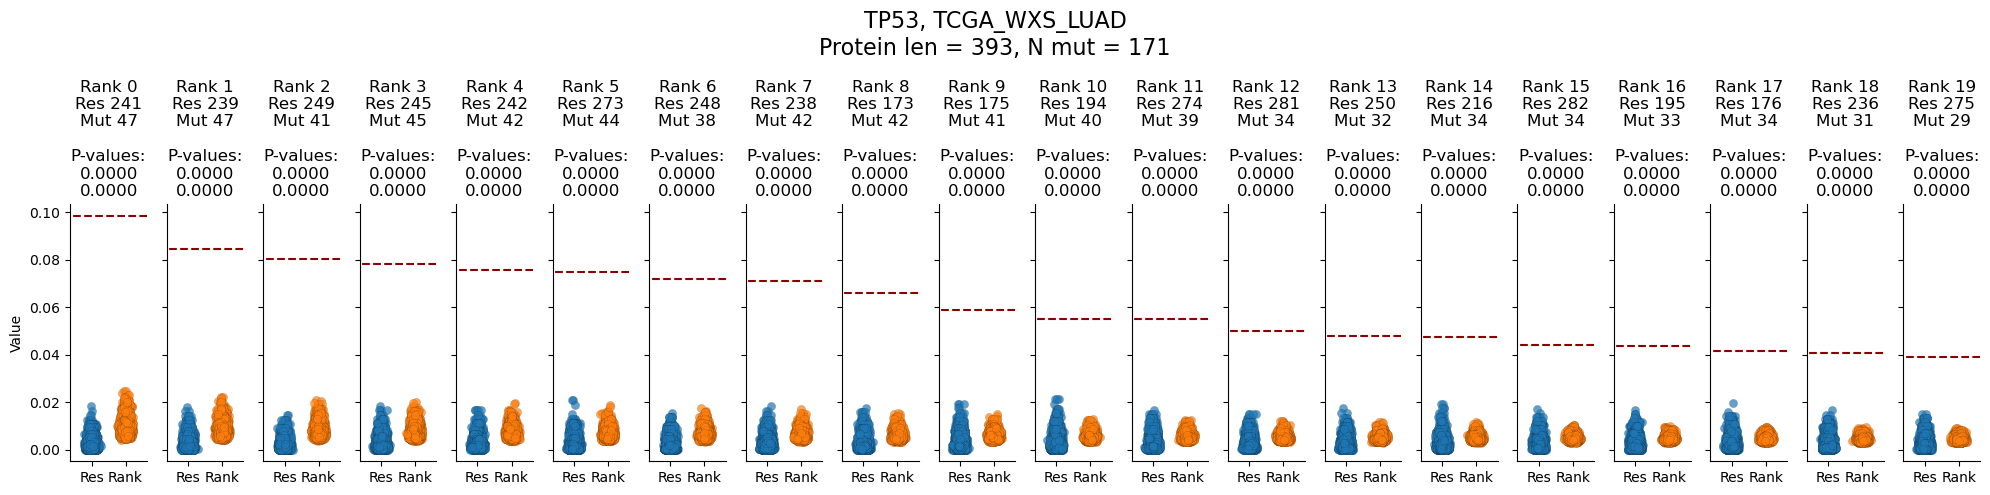

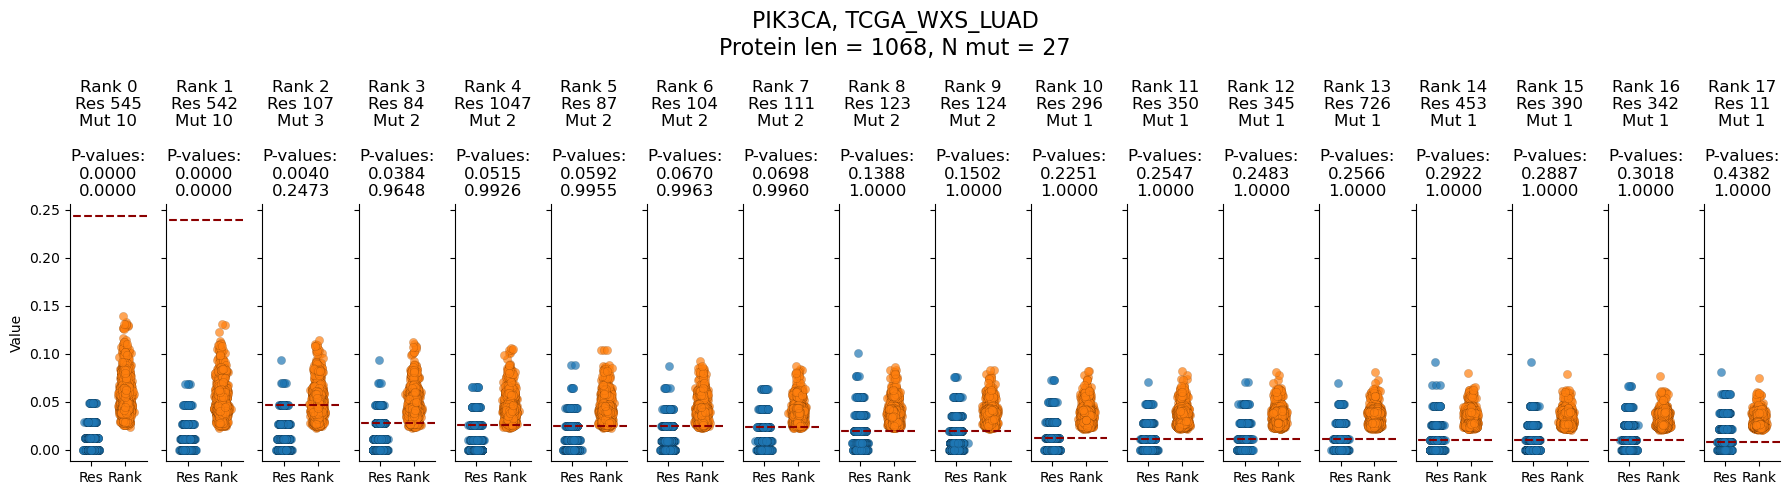

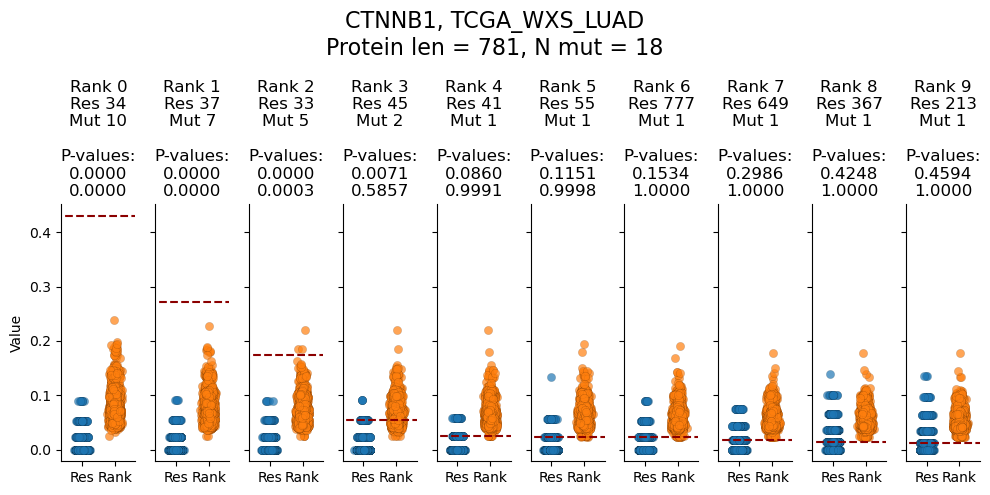

In [713]:
# Example of both True Positive
gene = "TP53"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df)

gene = "PIK3CA"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df)

gene = "CTNNB1"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df)

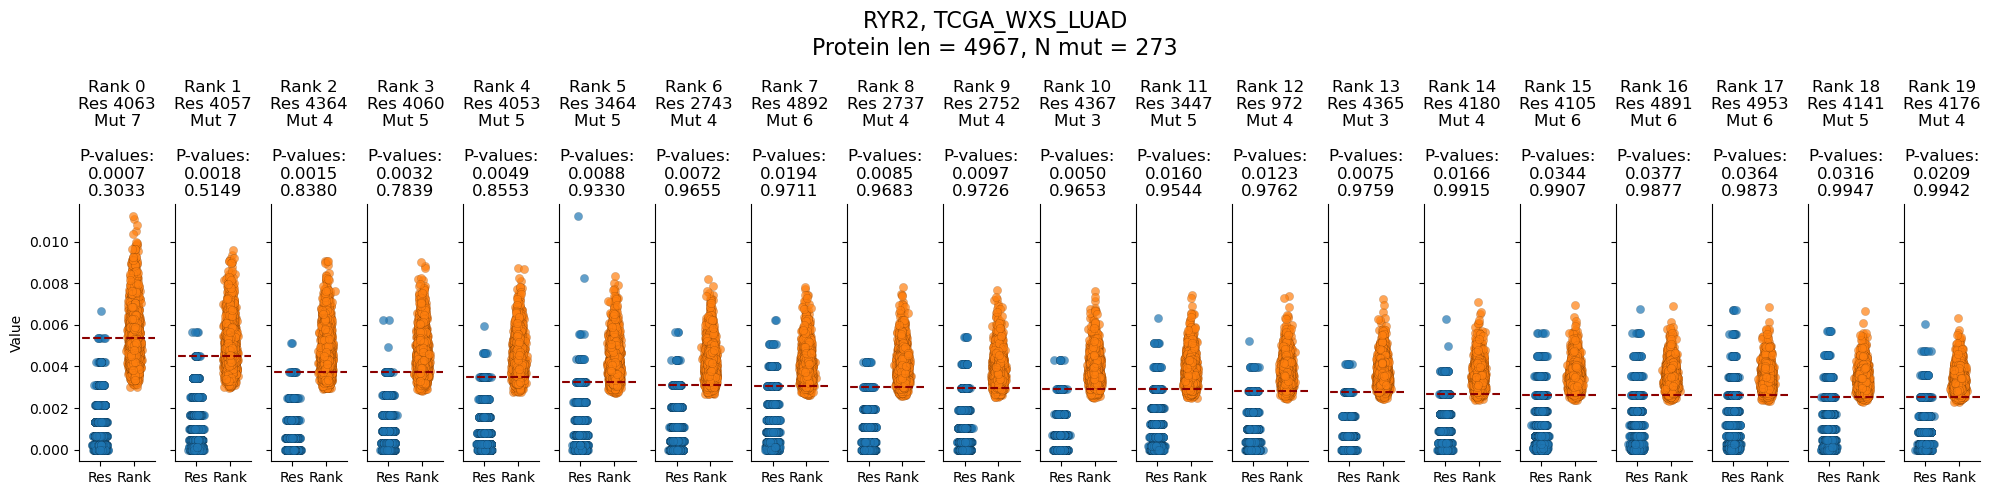

In [716]:
# Example of Res-based False Positive due to Long Protein
gene = "RYR2"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df)

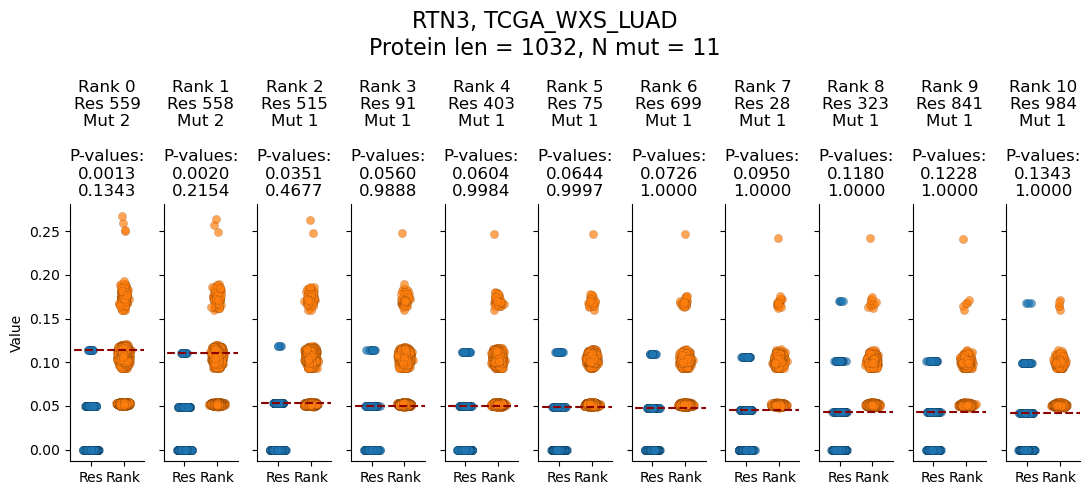

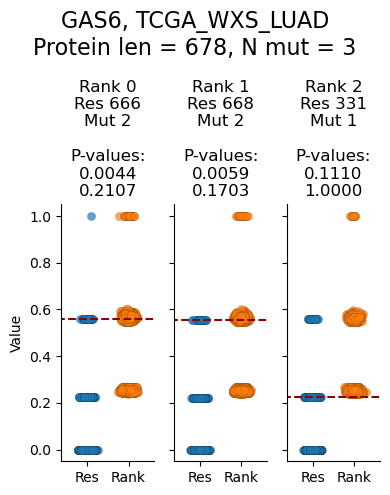

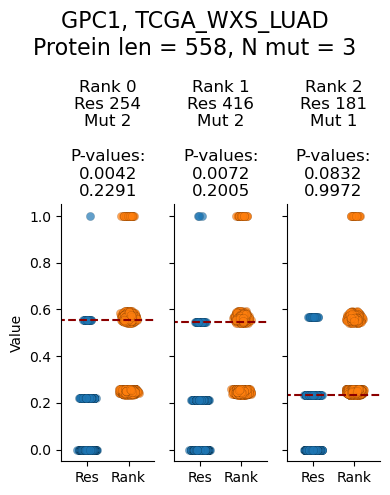

In [701]:
# Example of Res-based False Positive due to Low Number of Mutations
gene = "RTN3"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df)

gene = "GAS6"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df)

gene = "GPC1"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, mut_gene_df, gene, cohort, seq_df)

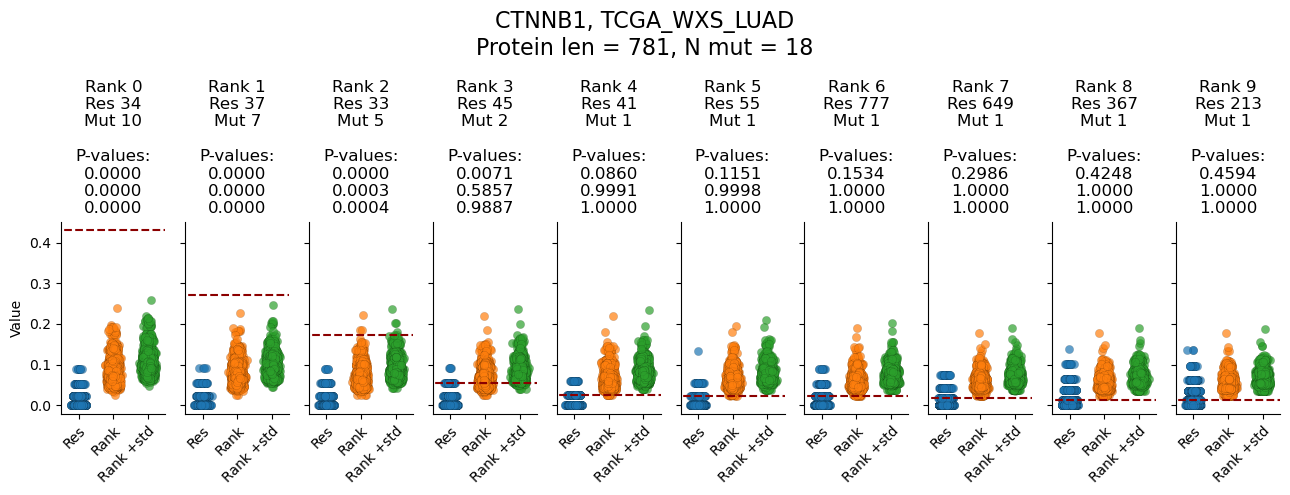

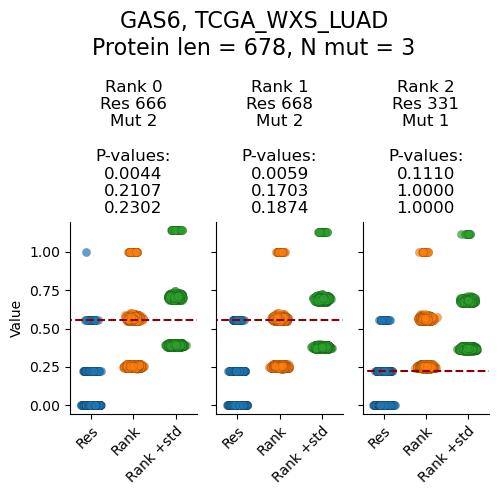

In [738]:
def plot_scores(result_pos_df, sim_scores_ranked, sim_scores_ranked_std, mut_gene_df, gene, cohort, seq_df, figsize=(10,5), n=20):
    
    n = len(result_pos_df) if n > len(result_pos_df) else n
    fig, axes = plt.subplots(1, n, figsize=figsize, sharey=True)
    categories = ['Res', 'Rank', "Rank +std"]
    protein_len = len(seq_df[seq_df["Gene"] == gene].Seq.values[0])

    # Plot each row in a subplot
    for i in range(n):
        ax = axes[i]
        pos = result_pos_df[result_pos_df["Rank"] == i].Pos.values[0]
        mut_in_vol = int(result_pos_df.iloc[i].Mut_in_vol)
        
        y_sim_scores_res = sim_scores.loc[sim_scores["index"]+1 == pos, 0:].values[0]
        y_sim_scores_rank = sim_scores_ranked.iloc[i, 1:].values
        y_sim_scores_rank_std = sim_scores_ranked_std.iloc[i, 1:].values
        obs_score = result_pos_df.iloc[i].Score
        
        pval_res = sum(y_sim_scores_res >= obs_score) / len(y_sim_scores_res)
        pval_rank = sum(y_sim_scores_rank >= obs_score) / len(y_sim_scores_rank)
        pval_rank_std = sum(y_sim_scores_rank_std >= obs_score) / len(y_sim_scores_rank_std)

        x1 = np.random.normal(-0.3, 0.05, size=len(y_sim_scores_res))
        x2 = np.random.normal(0.5, 0.05, size=len(y_sim_scores_rank))
        x3 = np.random.normal(1.3, 0.05, size=len(y_sim_scores_rank_std))

        ax.scatter(x1, y_sim_scores_res, alpha=0.7, ec="black", lw=0.1)
        ax.scatter(x2, y_sim_scores_rank, alpha=0.7, ec="black", lw=0.1)
        ax.scatter(x3, y_sim_scores_rank_std, alpha=0.7, ec="black", lw=0.1)
        ax.axhline(y=obs_score, xmin=-0.4, xmax=1.4, color='darkred', linestyle='--')

        ax.set_xticks([-0.3, 0.5, 1.3])
        ax.set_xticklabels(categories, rotation=45, ha='right', rotation_mode="anchor")
        ax.set_title(f'Rank {i}\nRes {pos}\nMut {mut_in_vol}\n\nP-values:\n{pval_res:.4f}\n{pval_rank:.4f}\n{pval_rank_std:.4f}')
        ax.set_xlim(-0.7, 1.7)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # Add shared y-axis label only to the first subplot
    axes[0].set_ylabel('Value')

    fig.suptitle(f'{gene}, {cohort}\nProtein len = {protein_len}, N mut = {len(mut_gene_df)}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    

# Addition of Standard deviation

gene = "CTNNB1"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, sim_scores_ranked_std, mut_gene_df, gene, cohort, seq_df, figsize=(13,5))

gene = "GAS6"
mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
plot_scores(result_pos_df, sim_scores_ranked, sim_scores_ranked_std, mut_gene_df, gene, cohort, seq_df, figsize=(5,5))

In [746]:
max_lst = []
min_lst = []
for gene in pd.DataFrame(data_tot_mut[:60]).index:
    mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
    max_lst.append(np.max(vol_missense_mut_prob))
    min_lst.append(np.min(vol_missense_mut_prob))

In [747]:
print(np.max(max_lst), np.mean(max_lst))
print(np.min(min_lst), np.mean(min_lst))


0.16464811012545022 0.019315243717457884
0.00025107372222217734 0.0013594537584913921


No_density
No_density
No_density
No_density


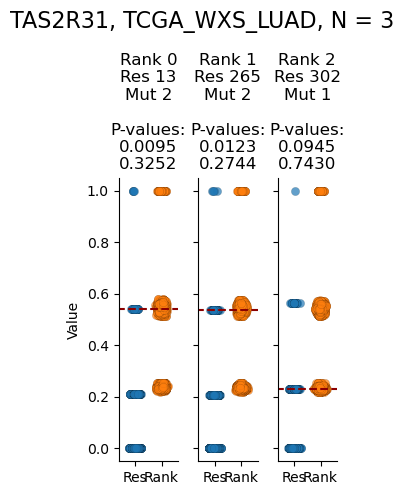

No_density
No_density


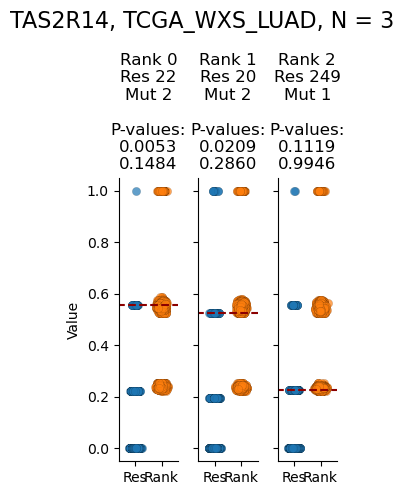

No_density
No_density
No_density
No_density
No_density
No_density
No_density
No_density
No_density
No_density
No_density


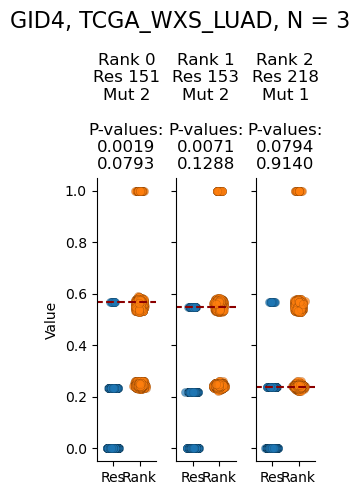

No_density
No_density
No_density
No_density
No_density
No_density
No_density
No_density


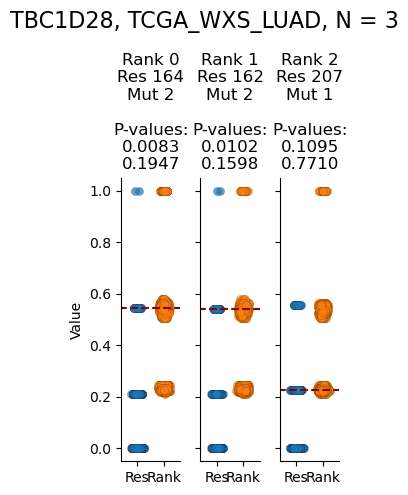

No_density
No_density
No_density
No_density


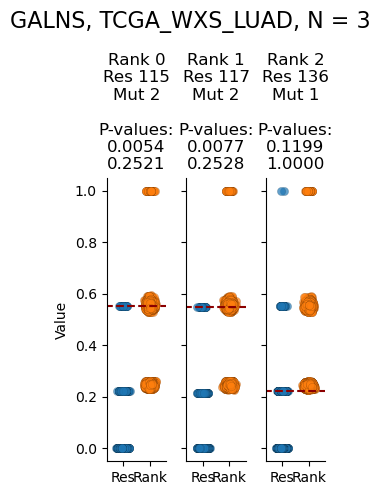

No_density
No_density
No_density
No_density


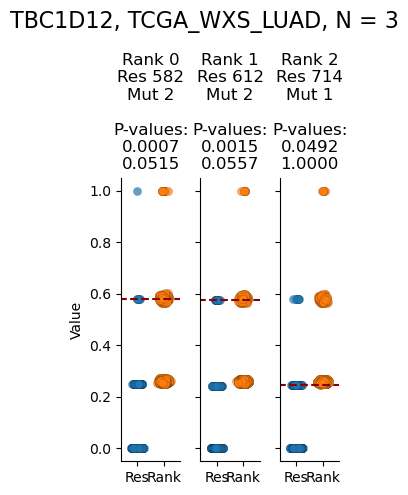

No_density
No_density
No_density
No_density
No_density
No_density


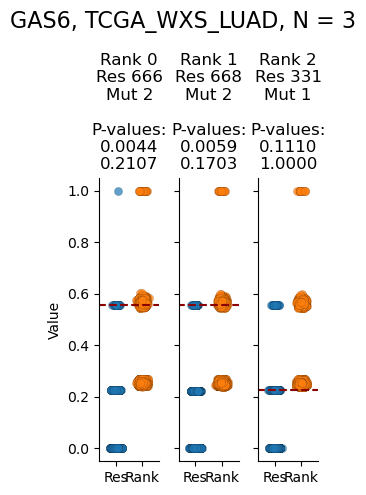

No_density
No_density
No_density
No_density
No_density


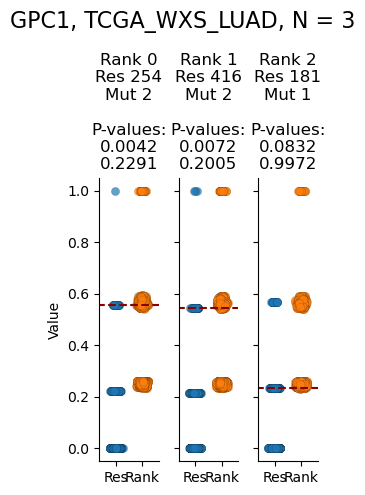

No_density
No_density
No_density
No_density
No_density
No_density
No_density
No_density


In [667]:
for gene in pd.DataFrame(data_tot_mut[:60]).index:
    mut_gene_df, vol_missense_mut_prob, gene_miss_prob, cmap = process_gene(gene, data, seq_df, cmap_path, miss_prob_dict)
    result_pos_df, sim_scores, sim_scores_std, sim_scores_ranked, sim_scores_ranked_std = get_scores(mut_gene_df, cmap, vol_missense_mut_prob, gene_miss_prob)
    if sum(result_pos_df.Mut_in_vol > 1) > 1:
        plot_scores(result_pos_df, mut_gene_df, gene, cohort, n=20)

In [681]:
data_tot_mut[data_tot_mut > 2].sort_values(ascending=False)[:250]

Gene
RYR2        273
CSMD3       257
LRP1B       229
USH2A       189
ZFHX4       186
TP53        171
KRAS        165
FLG         157
SPTA1       126
XIRP2       118
CSMD1       117
FAT3        110
NAV3        106
MUC17       102
ANK2        101
ZNF536       99
COL11A1      97
RP1L1        93
PCLO         93
RYR3         90
PAPPA2       90
PCDH15       89
RYR1         85
AHNAK2       84
ADAMTS12     83
SI           82
APOB         82
NRXN1        81
DNAH9        80
DMD          79
ADGRG4       76
PCDH11X      74
FAT4         73
CACNA1E      73
KEAP1        73
TNR          73
CDH10        73
NPAP1        72
MXRA5        72
NALCN        71
DST          71
ERICH3       70
PTPRD        69
FAM135B      69
ASXL3        67
PXDNL        67
ABCA13       67
RELN         66
HMCN1        64
PRDM9        64
OBSCN        64
VCAN         64
RIMS2        63
KMT2C        63
PRUNE2       63
ZNF804A      63
CSMD2        62
CNTNAP5      62
FBN2         62
FLG2         61
dtype: int64

In [644]:
data_tot_mut = data.groupby("Gene").apply(lambda x: len(x))
data_tot_mut = data_tot_mut[data_tot_mut > 2].sort_values()
data_tot_mut[:60]

Gene
A1BG        3
TAS2R42     3
GBP7        3
GCFC2       3
TAS2R31     3
TAS2R30     3
GCNT1       3
TAS2R14     3
GDPD5       3
TAS1R3      3
GATB        3
GEMIN4      3
GET3        3
GFI1        3
GFOD2       3
GFRA2       3
GGA3        3
GGT5        3
GGT6        3
GID4        3
TAPT1       3
GEMIN8      3
GATAD1      3
GATA2       3
GAS8        3
TBPL2       3
GABPA       3
TBL3        3
TBC1D28     3
GABRR3      3
GAGE10      3
TBC1D23     3
GALK1       3
GALNS       3
GALNT1      3
GALNT11     3
GALNT12     3
TBC1D15     3
TBC1D12     3
TBC1D10A    3
GALT        3
GAPDH       3
GAPT        3
TATDN3      3
GARS1       3
GAS6        3
GIN1        3
GINM1       3
GIPC2       3
GIT1        3
GPAT3       3
GPC1        3
GPC2        3
GPD1        3
GPER1       3
GPN2        3
GPR132      3
POPDC3      3
GPR137B     3
SYT12       3
dtype: int64